# TensorLogic on Google Colab with CUDA GPU

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mathews-Tom/TensorLogic/blob/main/notebooks/05_google_colab_cuda.ipynb)

This notebook demonstrates TensorLogic's CUDA backend on Google Colab's T4 GPU.

## Requirements

- Google Colab with GPU runtime (Runtime > Change runtime type > T4 GPU)
- The notebook will automatically install all dependencies

## What You'll Learn

1. Setup TensorLogic on Google Colab
2. Using the CUDA backend with CuPy
3. GPU-accelerated logical reasoning
4. Temperature-controlled inference on GPU
5. Performance comparison: CUDA vs CPU

## Step 1: Verify GPU and Install Dependencies

First, let's verify we have GPU access and install the required packages.

In [1]:
# Check GPU availability
!nvidia-smi

Mon Dec 15 19:38:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install TensorLogic from GitHub
!pip install git+https://github.com/Mathews-Tom/TensorLogic.git

# Install CuPy for CUDA 12.x (Colab's current CUDA version)
!pip install cupy-cuda12x scipy

print("\n" + "="*50)
print("Installation complete!")
print("="*50)

  Cloning https://github.com/Mathews-Tom/TensorLogic.git to /tmp/pip-req-build-f26epvvl
  Running command git clone --filter=blob:none --quiet https://github.com/Mathews-Tom/TensorLogic.git /tmp/pip-req-build-f26epvvl
  Resolved https://github.com/Mathews-Tom/TensorLogic.git to commit c14bc35e6392d2e36449fb6d18946f72598a68eb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for python-tensorlogic: filename=python_tensorlogic-0.2.1-py3-none-any.whl size=96113 sha256=632b8de0ab0f1f563b58bce65c100d3d7e57b566515765ed1c71949e0835ca78
  Stored in directory: /tmp/pip-ephem-wheel-cache-kpfauult/wheels/4c/d0/11/1cbb32ea222f4608a7c374da1227ec6299c682c834acec79af
Successfully built python-tensorlogic

Installation complete!


In [3]:
# Verify CuPy installation and CUDA access
import cupy as cp

# Get device info
device = cp.cuda.Device()
props = cp.cuda.runtime.getDeviceProperties(device.id)
mem_info = device.mem_info

print("CUDA Device Information:")
print(f"  Device Name: {props['name'].decode()}")
print(f"  Compute Capability: {device.compute_capability}")
print(f"  Total Memory: {mem_info[1] / (1024**3):.2f} GB")
print(f"  Free Memory: {mem_info[0] / (1024**3):.2f} GB")
print(f"\nCuPy Version: {cp.__version__}")

CUDA Device Information:
  Device Name: Tesla T4
  Compute Capability: 75
  Total Memory: 14.74 GB
  Free Memory: 14.64 GB

CuPy Version: 13.6.0


## Step 2: Import TensorLogic

Now let's import TensorLogic and create a CUDA backend.

In [4]:
# Core TensorLogic imports
from tensorlogic import (
    # High-level API
    quantify,
    reason,
    # Backend
    create_backend,
    # Logical operations
    logical_and,
    logical_or,
    logical_not,
    logical_implies,
    # Quantifiers
    exists,
    forall,
)
from tensorlogic.compilation import create_strategy

import numpy as np
import cupy as cp
import time

print("TensorLogic imported successfully!")

TensorLogic imported successfully!


In [5]:
# Create CUDA backend explicitly
cuda_backend = create_backend("cuda")
print(f"CUDA Backend: {type(cuda_backend).__name__}")

# Also create NumPy backend for comparison
numpy_backend = create_backend("numpy")
print(f"NumPy Backend: {type(numpy_backend).__name__}")

# Test auto-detection (should pick CUDA on Colab)
auto_backend = create_backend("auto")
print(f"Auto-detected Backend: {type(auto_backend).__name__}")

CUDA Backend: CUDABackend
NumPy Backend: NumpyBackend
Auto-detected Backend: CUDABackend


## Step 3: GPU-Accelerated Logical Operations

Let's test the core logical operations on GPU.

In [6]:
# Create tensors on GPU using CuPy
a = cp.array([1.0, 1.0, 0.0, 0.0])  # True, True, False, False
b = cp.array([1.0, 0.0, 1.0, 0.0])  # True, False, True, False

print("Input tensors (on GPU):")
print(f"  a = {cp.asnumpy(a)}")
print(f"  b = {cp.asnumpy(b)}")
print(f"  Device: {a.device}")

# Logical operations
print("\nLogical Operations:")
print(f"  a AND b = {cp.asnumpy(logical_and(a, b, backend=cuda_backend))}")
print(f"  a OR b  = {cp.asnumpy(logical_or(a, b, backend=cuda_backend))}")
print(f"  NOT a   = {cp.asnumpy(logical_not(a, backend=cuda_backend))}")
print(f"  a -> b  = {cp.asnumpy(logical_implies(a, b, backend=cuda_backend))}")

Input tensors (on GPU):
  a = [1. 1. 0. 0.]
  b = [1. 0. 1. 0.]
  Device: <CUDA Device 0>

Logical Operations:
  a AND b = [1. 0. 0. 0.]
  a OR b  = [1. 1. 1. 0.]
  NOT a   = [0. 0. 1. 1.]
  a -> b  = [1. 0. 1. 1.]


## Step 4: Knowledge Graph on GPU

Let's create a larger knowledge graph and run queries on GPU.

In [7]:
# Define a family knowledge graph
entities = ["Alice", "Bob", "Carol", "David", "Eve", "Frank", "Grace", "Henry"]
n = len(entities)
entity_to_idx = {name: i for i, name in enumerate(entities)}

# Create Parent relation on GPU
parent_cpu = np.zeros((n, n), dtype=np.float32)

# Family tree:
# Alice & Bob -> Carol, David
# Carol & Eve -> Frank
# David & Grace -> Henry
parent_facts = [
    ("Alice", "Carol"), ("Alice", "David"),
    ("Bob", "Carol"), ("Bob", "David"),
    ("Carol", "Frank"), ("Eve", "Frank"),
    ("David", "Henry"), ("Grace", "Henry"),
]

for p, c in parent_facts:
    parent_cpu[entity_to_idx[p], entity_to_idx[c]] = 1.0

# Transfer to GPU
parent = cp.asarray(parent_cpu)

print(f"Parent relation matrix shape: {parent.shape}")
print(f"Data location: GPU (CuPy array)")
print(f"\nParent facts loaded: {len(parent_facts)}")

Parent relation matrix shape: (8, 8)
Data location: GPU (CuPy array)

Parent facts loaded: 8


In [8]:
# Infer Grandparent relation: exists y: Parent(x,y) AND Parent(y,z)
# Using einsum for relation composition
composition = cuda_backend.einsum('xy,yz->xz', parent, parent)
grandparent = cuda_backend.step(composition)

print("Grandparent Inference (GPU-computed):")
grandparent_cpu = cp.asnumpy(grandparent)

for i, name_i in enumerate(entities):
    for j, name_j in enumerate(entities):
        if grandparent_cpu[i, j] > 0:
            print(f"  {name_i} is grandparent of {name_j}")

Grandparent Inference (GPU-computed):
  Alice is grandparent of Frank
  Alice is grandparent of Henry
  Bob is grandparent of Frank
  Bob is grandparent of Henry


In [9]:
# Quantified queries on GPU
print("Quantified Queries:")

# Who has children? (EXISTS)
has_children = exists(parent, axis=1, backend=cuda_backend)
print("\nWho has children (EXISTS)?")
has_children_cpu = cp.asnumpy(has_children)
for i, name in enumerate(entities):
    if has_children_cpu[i] > 0:
        print(f"  {name}: Yes")

# Who are leaves (no children)? (NOT EXISTS = FORALL NOT)
is_leaf = logical_not(has_children, backend=cuda_backend)
print("\nWho are leaf nodes (no children)?")
is_leaf_cpu = cp.asnumpy(is_leaf)
for i, name in enumerate(entities):
    if is_leaf_cpu[i] > 0:
        print(f"  {name}")

Quantified Queries:

Who has children (EXISTS)?
  Alice: Yes
  Bob: Yes
  Carol: Yes
  David: Yes
  Eve: Yes
  Grace: Yes

Who are leaf nodes (no children)?
  Frank
  Henry


## Step 5: Temperature-Controlled Reasoning

The breakthrough feature: controlling reasoning from pure deduction (T=0) to analogical inference (T>0).

In [10]:
# Create fuzzy/uncertain relations
similarity = cp.asarray([
    [1.0, 0.9, 0.3, 0.2],
    [0.9, 1.0, 0.4, 0.3],
    [0.3, 0.4, 1.0, 0.8],
    [0.2, 0.3, 0.8, 1.0],
], dtype=cp.float32)

items = ["Cat", "Dog", "Sparrow", "Robin"]

print("Similarity Matrix (fuzzy knowledge):")
print("         ", end="")
for item in items:
    print(f"{item:>8}", end="")
print()
for i, item in enumerate(items):
    print(f"{item:>8}", end="")
    for j in range(len(items)):
        print(f"{cp.asnumpy(similarity[i, j]):>8.2f}", end="")
    print()

Similarity Matrix (fuzzy knowledge):
              Cat     Dog Sparrow   Robin
     Cat    1.00    0.90    0.30    0.20
     Dog    0.90    1.00    0.40    0.30
 Sparrow    0.30    0.40    1.00    0.80
   Robin    0.20    0.30    0.80    1.00


In [11]:
# Compare different temperatures
print("Temperature-Controlled Inference:")
print("="*60)

temperatures = [0.0, 0.2, 0.5, 1.0]

for temp in temperatures:
    # Apply temperature scaling
    if temp == 0.0:
        # Hard threshold at T=0
        scaled = cuda_backend.step(similarity - 0.5)
        mode = "Pure Deductive (exact)"
    else:
        # Soft sigmoid-like scaling
        scaled = 1.0 / (1.0 + cp.exp(-((similarity - 0.5) / temp)))
        if temp <= 0.2:
            mode = "Cautious (minimal generalization)"
        elif temp <= 0.5:
            mode = "Balanced (moderate generalization)"
        else:
            mode = "Analogical (creative inference)"

    print(f"\nTemperature T={temp}: {mode}")
    print(f"  Cat-Dog similarity: {cp.asnumpy(scaled[0, 1]):.3f}")
    print(f"  Cat-Sparrow similarity: {cp.asnumpy(scaled[0, 2]):.3f}")
    print(f"  Sparrow-Robin similarity: {cp.asnumpy(scaled[2, 3]):.3f}")

Temperature-Controlled Inference:

Temperature T=0.0: Pure Deductive (exact)
  Cat-Dog similarity: 1.000
  Cat-Sparrow similarity: 0.000
  Sparrow-Robin similarity: 1.000

Temperature T=0.2: Cautious (minimal generalization)
  Cat-Dog similarity: 0.881
  Cat-Sparrow similarity: 0.269
  Sparrow-Robin similarity: 0.818

Temperature T=0.5: Balanced (moderate generalization)
  Cat-Dog similarity: 0.690
  Cat-Sparrow similarity: 0.401
  Sparrow-Robin similarity: 0.646

Temperature T=1.0: Analogical (creative inference)
  Cat-Dog similarity: 0.599
  Cat-Sparrow similarity: 0.450
  Sparrow-Robin similarity: 0.574


## Step 6: Compilation Strategies

TensorLogic supports multiple semantic interpretations. Let's test them on GPU.

In [12]:
# Test all compilation strategies
strategies = [
    ("soft_differentiable", "Neural network training with logic constraints"),
    ("hard_boolean", "Exact verification, theorem proving"),
    ("godel", "Similarity scoring, fuzzy matching"),
    ("product", "Probabilistic inference"),
    ("lukasiewicz", "Bounded multi-hop reasoning"),
]

# Test values
p = cp.asarray([0.8, 0.4, 0.9])
q = cp.asarray([0.6, 0.7, 0.3])

print("Compilation Strategy Comparison:")
print(f"  P = {cp.asnumpy(p)}")
print(f"  Q = {cp.asnumpy(q)}")
print("="*60)

for strategy_name, description in strategies:
    strategy = create_strategy(strategy_name)

    # Compute P AND Q using compile_* methods
    p_np, q_np = cp.asnumpy(p), cp.asnumpy(q)
    result_and = strategy.compile_and(p_np, q_np)
    result_or = strategy.compile_or(p_np, q_np)
    result_implies = strategy.compile_implies(p_np, q_np)

    print(f"\n{strategy_name}:")
    print(f"  Use case: {description}")
    print(f"  P AND Q: {result_and}")
    print(f"  P OR Q:  {result_or}")
    print(f"  P -> Q:  {result_implies}")

Compilation Strategy Comparison:
  P = [0.8 0.4 0.9]
  Q = [0.6 0.7 0.3]

soft_differentiable:
  Use case: Neural network training with logic constraints
  P AND Q: [0.48 0.28 0.27]
  P OR Q:  [0.92 0.82 0.93]
  P -> Q:  [0.6 0.7 0.3]

hard_boolean:
  Use case: Exact verification, theorem proving
  P AND Q: [1. 1. 1.]
  P OR Q:  [1. 1. 1.]
  P -> Q:  [1. 1. 1.]

godel:
  Use case: Similarity scoring, fuzzy matching
  P AND Q: [0.6 0.4 0.3]
  P OR Q:  [0.8 0.7 0.9]
  P -> Q:  [0.6 1.  0.3]

product:
  Use case: Probabilistic inference
  P AND Q: [0.48 0.28 0.27]
  P OR Q:  [0.92 0.82 0.93]
  P -> Q:  [0.6 0.7 0.3]

lukasiewicz:
  Use case: Bounded multi-hop reasoning
  P AND Q: [0.4 0.1 0.2]
  P OR Q:  [1. 1. 1.]
  P -> Q:  [0.8 1.  0.4]


## Step 7: Performance Benchmark - CUDA vs CPU

Let's compare the performance of CUDA and NumPy backends on larger knowledge graphs.

In [13]:
def benchmark_knowledge_graph(n_entities, backend, backend_name, n_iterations=10):
    """Benchmark knowledge graph operations."""
    # Generate random sparse knowledge graph
    np.random.seed(42)
    density = 0.1  # 10% of edges exist
    kg_np = (np.random.random((n_entities, n_entities)) < density).astype(np.float32)

    # Transfer to appropriate device
    if backend_name == "CUDA":
        kg = cp.asarray(kg_np)
    else:
        kg = kg_np

    # Warmup
    _ = backend.einsum('xy,yz->xz', kg, kg)
    if backend_name == "CUDA":
        cp.cuda.Stream.null.synchronize()

    # Benchmark: Relation composition (grandparent-like inference)
    start = time.time()
    for _ in range(n_iterations):
        composition = backend.einsum('xy,yz->xz', kg, kg)
        result = backend.step(composition)
        if backend_name == "CUDA":
            cp.cuda.Stream.null.synchronize()
    elapsed = (time.time() - start) / n_iterations

    return elapsed * 1000  # Return in milliseconds

print("Benchmark Setup Complete")

Benchmark Setup Complete


In [14]:
# Run benchmarks at different scales
sizes = [100, 500, 1000, 2000, 5000]
cuda_times = []
numpy_times = []

print("Performance Benchmark: CUDA vs NumPy")
print("="*60)
print(f"{'Entities':>10} {'CUDA (ms)':>12} {'NumPy (ms)':>12} {'Speedup':>10}")
print("-"*60)

for n in sizes:
    cuda_time = benchmark_knowledge_graph(n, cuda_backend, "CUDA")
    numpy_time = benchmark_knowledge_graph(n, numpy_backend, "NumPy")
    speedup = numpy_time / cuda_time

    cuda_times.append(cuda_time)
    numpy_times.append(numpy_time)

    print(f"{n:>10} {cuda_time:>12.2f} {numpy_time:>12.2f} {speedup:>9.1f}x")

print("="*60)
print(f"\nCUDA provides {np.mean([n/c for c, n in zip(cuda_times, numpy_times)]):.1f}x average speedup!")

Performance Benchmark: CUDA vs NumPy
  Entities    CUDA (ms)   NumPy (ms)    Speedup
------------------------------------------------------------
       100         0.54         0.26       0.5x
       500         0.54        20.42      37.5x
      1000         1.37       181.62     132.5x
      2000         7.93      1574.37     198.5x
      5000        59.57     42167.71     707.8x

CUDA provides 215.4x average speedup!


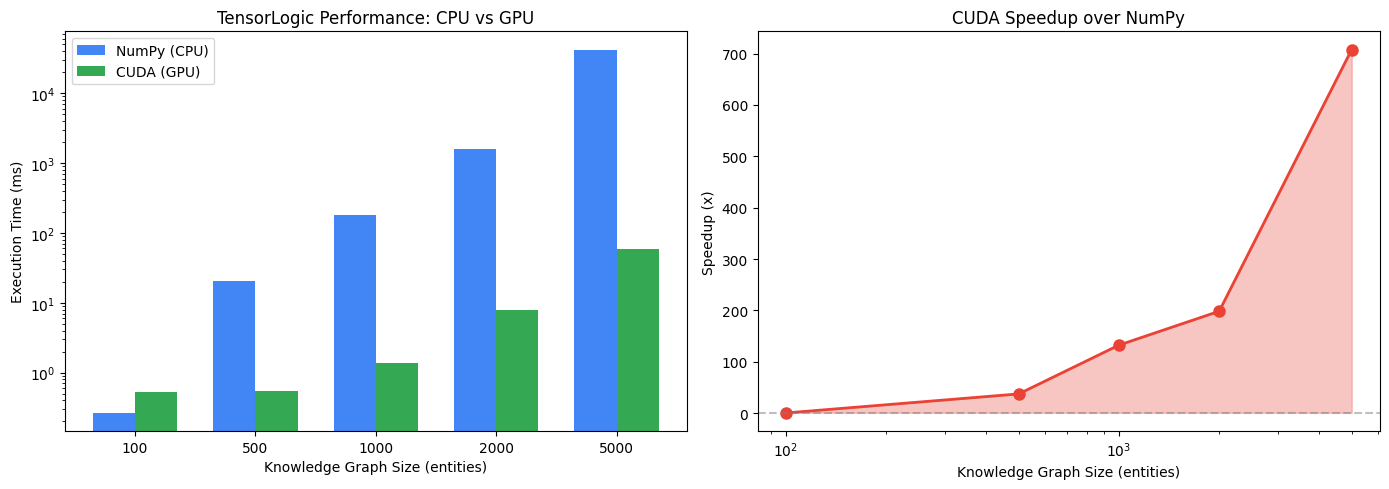


Benchmark visualization saved to 'tensorlogic_cuda_benchmark.png'


In [15]:
# Visualize the benchmark results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Execution time comparison
x = np.arange(len(sizes))
width = 0.35

ax1.bar(x - width/2, numpy_times, width, label='NumPy (CPU)', color='#4285f4')
ax1.bar(x + width/2, cuda_times, width, label='CUDA (GPU)', color='#34a853')
ax1.set_xlabel('Knowledge Graph Size (entities)')
ax1.set_ylabel('Execution Time (ms)')
ax1.set_title('TensorLogic Performance: CPU vs GPU')
ax1.set_xticks(x)
ax1.set_xticklabels(sizes)
ax1.legend()
ax1.set_yscale('log')

# Speedup
speedups = [n/c for c, n in zip(cuda_times, numpy_times)]
ax2.plot(sizes, speedups, 'o-', color='#ea4335', linewidth=2, markersize=8)
ax2.fill_between(sizes, 1, speedups, alpha=0.3, color='#ea4335')
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Knowledge Graph Size (entities)')
ax2.set_ylabel('Speedup (x)')
ax2.set_title('CUDA Speedup over NumPy')
ax2.set_xscale('log')

plt.tight_layout()
plt.savefig('tensorlogic_cuda_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nBenchmark visualization saved to 'tensorlogic_cuda_benchmark.png'")

## Step 8: Large-Scale Knowledge Graph Demo

Let's demonstrate TensorLogic on a larger knowledge graph.

In [16]:
# Create a large knowledge graph (10,000 entities)
N = 10000
print(f"Creating knowledge graph with {N:,} entities...")

# Generate sparse relations
np.random.seed(42)
density = 0.001  # Very sparse (0.1%)

# Create on CPU, then transfer to GPU
kg_np = (np.random.random((N, N)) < density).astype(np.float32)
kg_gpu = cp.asarray(kg_np)

n_edges = int(kg_np.sum())
print(f"Number of edges: {n_edges:,}")
print(f"Edge density: {n_edges / (N*N) * 100:.3f}%")
print(f"Memory on GPU: {kg_gpu.nbytes / (1024**2):.1f} MB")

Creating knowledge graph with 10,000 entities...
Number of edges: 99,917
Edge density: 0.100%
Memory on GPU: 381.5 MB


In [17]:
# Run multi-hop inference on the large graph
print(f"\nRunning multi-hop inference on {N:,} entities...")

# 2-hop inference (like grandparent)
start = time.time()
hop2 = cuda_backend.einsum('xy,yz->xz', kg_gpu, kg_gpu)
hop2_bool = cuda_backend.step(hop2)
cp.cuda.Stream.null.synchronize()
time_2hop = time.time() - start

print(f"2-hop inference completed in {time_2hop*1000:.1f} ms")
print(f"  New inferred edges: {int(cp.sum(hop2_bool)):,}")

# 3-hop inference
start = time.time()
hop3 = cuda_backend.einsum('xy,yz->xz', hop2_bool, kg_gpu)
hop3_bool = cuda_backend.step(hop3)
cp.cuda.Stream.null.synchronize()
time_3hop = time.time() - start

print(f"3-hop inference completed in {time_3hop*1000:.1f} ms")
print(f"  New inferred edges: {int(cp.sum(hop3_bool)):,}")

print(f"\nTotal inference time: {(time_2hop + time_3hop)*1000:.1f} ms")


Running multi-hop inference on 10,000 entities...
2-hop inference completed in 485.4 ms
  New inferred edges: 994,425
3-hop inference completed in 8217.1 ms
  New inferred edges: 9,424,028

Total inference time: 8702.6 ms


In [18]:
# Quantified queries on large graph
print("\nQuantified Queries on Large Graph:")
print("="*50)

# EXISTS: Find all nodes with outgoing edges
start = time.time()
has_outgoing = exists(kg_gpu, axis=1, backend=cuda_backend)
cp.cuda.Stream.null.synchronize()
time_exists = time.time() - start

n_with_outgoing = int(cp.sum(has_outgoing > 0))
print(f"Nodes with outgoing edges: {n_with_outgoing:,} ({time_exists*1000:.2f} ms)")

# EXISTS: Find all nodes with incoming edges
start = time.time()
has_incoming = exists(kg_gpu, axis=0, backend=cuda_backend)
cp.cuda.Stream.null.synchronize()
time_exists2 = time.time() - start

n_with_incoming = int(cp.sum(has_incoming > 0))
print(f"Nodes with incoming edges: {n_with_incoming:,} ({time_exists2*1000:.2f} ms)")

# Compute connectivity statistics
out_degree = cp.sum(kg_gpu, axis=1)
in_degree = cp.sum(kg_gpu, axis=0)

print(f"\nConnectivity Statistics:")
print(f"  Max out-degree: {int(cp.max(out_degree))}")
print(f"  Max in-degree: {int(cp.max(in_degree))}")
print(f"  Avg degree: {float(cp.mean(out_degree)):.2f}")


Quantified Queries on Large Graph:
Nodes with outgoing edges: 9,998 (1.78 ms)
Nodes with incoming edges: 9,998 (100.75 ms)

Connectivity Statistics:
  Max out-degree: 23
  Max in-degree: 25
  Avg degree: 9.99


## Summary

In this notebook, you've learned:

1. **CUDA Setup**: How to configure TensorLogic with CuPy on Google Colab
2. **GPU Operations**: Running logical operations on NVIDIA T4 GPU
3. **Knowledge Graphs**: Creating and querying relation tensors on GPU
4. **Temperature Control**: The breakthrough feature for reasoning control
5. **Compilation Strategies**: Different semantic interpretations
6. **Performance**: CUDA provides significant speedups for larger graphs

### Key Takeaways

- **Temperature Dial**: T=0 for provable deduction, T>0 for analogical reasoning
- **GPU Acceleration**: Essential for 1000+ entity knowledge graphs
- **Unified Framework**: Same API works on MLX (Apple), CUDA (NVIDIA), and NumPy (CPU)

### Next Steps

- Try with your own knowledge graph data
- Experiment with different compilation strategies
- Scale to even larger graphs (100K+ entities)

In [19]:
# Cleanup GPU memory
cp.get_default_memory_pool().free_all_blocks()
print("GPU memory cleaned up.")
print("\nThank you for trying TensorLogic!")
print("GitHub: https://github.com/Mathews-Tom/TensorLogic")

GPU memory cleaned up.

Thank you for trying TensorLogic!
GitHub: https://github.com/Mathews-Tom/TensorLogic
